<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project1/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 1 report

## Pierre Segonne 490547607

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on online GPU servers, e.g. [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab (e.g, if you are use lab machines, your own computers or AWS servers (Windows)).

In [1]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 5.4MB/s 
ERROR: torchvision 0.4.0 has requirement torch==1.2.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 2.9MB/s 
  Found existing installation: torchvision 0.4.0
    Uninstalling torchvision-0.4.0:
      Successfully uninstalled torchvision-0.4.0


In [0]:
# upload files to Colab
from google.colab import files
files.upload()

{}

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [0]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

# OWN 
import numpy as np


In [25]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [0]:
# Your split codes here.
# You need to random select the 5000 validation images 

# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

from torch.utils.data import SubsetRandomSampler

VALIDATION_SET_SIZE = 5000
BATCH_SIZE = 4

"""
For debug purposes, we want to use only a small portion of the dataset.
"""
DEBUG = True

if DEBUG:
    indices = np.arange(200)
    np.random.shuffle(indices)
    split = int(len(indices)*0.8)
else:
    indices = np.arange(len(trainset))
    np.random.shuffle(indices) # for shuffle = True
    split = len(trainset) - VALIDATION_SET_SIZE

validation_set_size = len(indices) - split

train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])
    
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=2,
                                           sampler=train_sampler
                                          )
validation_loader = torch.utils.data.DataLoader(trainset,
                                                batch_size=BATCH_SIZE,
                                                num_workers=2,
                                                sampler=validation_sampler
                                               )



### 1.3 Define a Baseline Convolution Neural Network

In [0]:
# Omission
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 Define a Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [31]:
# own:
trainloader = train_loader
validationloader = validation_loader

if DEBUG:
    print_every = 20
else:
    print_every = 2000
    
training_loss = []
validation_loss = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == (print_every - 1):
            
            # Training loss
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            training_loss.append(running_loss / print_every)
            running_loss = 0.0
            
            # Validation loss
            running_validation_loss = 0
            for indices, data in enumerate(validationloader, 0):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_validation_loss += loss.item()
            validation_loss.append(running_validation_loss / (validation_set_size/BATCH_SIZE))

print('Finished Training')

[1,    20] loss: 2.277
[1,    40] loss: 2.293
[2,    20] loss: 2.282
[2,    40] loss: 2.285
[3,    20] loss: 2.269
[3,    40] loss: 2.293
[4,    20] loss: 2.275
[4,    40] loss: 2.281
[5,    20] loss: 2.281
[5,    40] loss: 2.270
[6,    20] loss: 2.261
[6,    40] loss: 2.287
[7,    20] loss: 2.246
[7,    40] loss: 2.296
[8,    20] loss: 2.262
[8,    40] loss: 2.271
[9,    20] loss: 2.247
[9,    40] loss: 2.281
[10,    20] loss: 2.257
[10,    40] loss: 2.257
[11,    20] loss: 2.250
[11,    40] loss: 2.257
[12,    20] loss: 2.221
[12,    40] loss: 2.274
[13,    20] loss: 2.227
[13,    40] loss: 2.262
[14,    20] loss: 2.225
[14,    40] loss: 2.205
[15,    20] loss: 2.183
[15,    40] loss: 2.227
[16,    20] loss: 2.133
[16,    40] loss: 2.228
[17,    20] loss: 2.176
[17,    40] loss: 2.166
[18,    20] loss: 2.142
[18,    40] loss: 2.160
[19,    20] loss: 2.080
[19,    40] loss: 2.194
[20,    20] loss: 2.137
[20,    40] loss: 2.108
[21,    20] loss: 2.151
[21,    40] loss: 2.001
[22,    20

### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

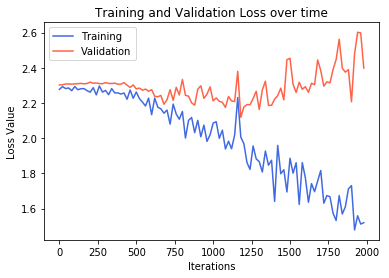

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss
iterations = np.arange(len(training_loss)) * print_every
plt.figure()
plt.title('Training and Validation Loss over time')
plt.plot(iterations, training_loss, '-', color='royalblue')
plt.plot(iterations, validation_loss, '-', color='tomato')
plt.legend(['Training', 'Validation'])
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.show()


### 1.7 Eval the trained network

In [0]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Own
    accuracy = 100 * correct / total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))
    return accuracy

EVAL_INITIAL = False
if EVAL_INITIAL:
  eval_net(net, testloader)

### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:
2. Base learning rate:
3. Number of epochs: 

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

### Google Colab File Saving UTILS

In [0]:
ROOT_DIRECTORY = '.'

In [16]:
"""
Allow saving files to google drive if ran on colab.
Useful to keep records of loss evolution for different training runs
And to save figures.

Not required to run the code.
"""
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/ELEC5307 Project1'




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Definition of the Samplers

In [0]:
from torch.utils.data import SubsetRandomSampler

"""
For debug purposes, we want to use only a small portion of the dataset.
"""
DEBUG = False
VALIDATED_SET_SIZE = 5000
"""
To test out the training with different hyperparameters, we want to use only
a scaled down (in terms of number of images) version of the dataset.
"""
ACCELERATED_TRAINING = True

if DEBUG:
    indices = np.arange(200)
    np.random.shuffle(indices)
    split = int(len(indices)*0.8)
    RECORD_EVERY = 20
elif ACCELERATED_TRAINING:
    # Defines by what factor to divide the size of the dataset for accelerated training.
    SCALING_FACTOR = 5
    indices = np.arange(int(len(trainset)/SCALING_FACTOR))
    np.random.shuffle(indices)
    split = int(len(indices)*0.8) # Can't use 5000 values for validation, use more traditional 80/20 split
    RECORD_EVERY = int(2000 / SCALING_FACTOR)
else:
    indices = np.arange(len(trainset))
    np.random.shuffle(indices)
    split = len(trainset) - VALIDATION_SET_SIZE
    RECORD_EVERY = 2000


validation_set_size = len(indices) - split

train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])

### Training Function

In [0]:
import os
import pickle
import matplotlib.pyplot as plt
import torch.optim as optim

def serializeObject(obj, fileName):
    with open(fileName, 'wb') as fileHandler:
        pickle.dump(obj, fileHandler, protocol=pickle.HIGHEST_PROTOCOL)

def readPickled(fileName):
    pickledData = {}
    try:
        if os.path.getsize(fileName) > 0:      
            with open(fileName, "rb") as f:
                unpickler = pickle.Unpickler(f)
                # if file is not empty scores will be equal
                # to the value unpickled
                pickledData = unpickler.load()
    except FileNotFoundError:
        raise FileNotFoundError('FILE NOT FOUND!: {0}'.format(fileName))
    return pickledData

def train_network(ann, train_loader, validation_loader,
                  batch_size=2, lr=0.0001, epoch=2,
                  download=False, root_directory='',
                  record_every=20):
  
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ann.parameters(), lr=lr, momentum=0.9)
    
    training_loss = []
    validation_loss = []  

    validation_set_size = len(validation_loader.sampler)

    for e in range(epoch):
        
        running_loss = 0.
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = ann(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % record_every == (record_every - 1):
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / record_every))
                # Training loss
                training_loss.append(running_loss / record_every)
                running_loss = 0.0
            
                # Validation loss
                running_validation_loss = 0
                for indices, data in enumerate(validation_loader, 0):
                    inputs, labels = data
                    outputs = ann(inputs)
                    loss = criterion(outputs, labels)
                    running_validation_loss += loss.item()
                validation_loss.append(running_validation_loss / (validation_set_size/batch_size))
    
    
    if download:
        dir_name = '{0}/training_recording/bs{1},lr{2},epoch{3}'.format(root_directory, batch_size, lr, epoch)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        
        # Save losses for eventual future use
        serializeObject(training_loss, dir_name + '/training_loss.pickle')
        serializeObject(validation_loss, dir_name + '/validation_loss.pickle')

        # Save network weights for eventual future use
        torch.save(ann.state_dict(), dir_name + '/network_weights.pickle')
        
        iterations = np.arange(len(training_loss))*record_every
        plt.figure()
        plt.title('Training and Validation Loss During Training')
        plt.xlabel('Iterations')
        plt.ylabel('Loss Value')
        plt.plot(iterations, training_loss, '-', color='royalblue')
        plt.plot(iterations, validation_loss, '-', color='tomato')
        plt.legend(['Training', 'Validation'])
        plt.savefig(dir_name + '/e{0},lr{1},bs{2}.png'.format(epoch, lr, batch_size), bbox_inches='tight')

        
    
    return ann

### Evaluation of the Parameters

In [0]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.
batch_sizes = [2, 4, 8]
learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
epochs = [1, 2, 4, 8, 16]

'''
How to do that though? If we test all combinations, we end up with 90 models to test. 
We could decrease that number by manually removing options:
[4,8]
[0.0005, 0.0001, 0.00005]
[2,4,8]
-> 18, much more reasonable

We save data and plots for all and study the variations.
'''
batch_sizes = [4, 8]
learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
epochs = [8, 16]


[1,   400] loss: 2.303
[1,   800] loss: 2.274
[1,  1200] loss: 2.206
[1,  1600] loss: 2.115
[1,  2000] loss: 2.070
[2,   400] loss: 2.014
[2,   800] loss: 1.985
[2,  1200] loss: 1.932
[2,  1600] loss: 1.932
[2,  2000] loss: 1.977
[3,   400] loss: 1.949
[3,   800] loss: 1.921
[3,  1200] loss: 1.923
[3,  1600] loss: 1.866
[3,  2000] loss: 1.878
[4,   400] loss: 1.832
[4,   800] loss: 1.849
[4,  1200] loss: 1.897
[4,  1600] loss: 1.861
[4,  2000] loss: 1.892
[5,   400] loss: 1.833
[5,   800] loss: 1.842
[5,  1200] loss: 1.854
[5,  1600] loss: 1.888
[5,  2000] loss: 1.824
[6,   400] loss: 1.771
[6,   800] loss: 1.810
[6,  1200] loss: 1.822
[6,  1600] loss: 1.859
[6,  2000] loss: 1.815
[7,   400] loss: 1.756
[7,   800] loss: 1.765
[7,  1200] loss: 1.852
[7,  1600] loss: 1.810
[7,  2000] loss: 1.808
[8,   400] loss: 1.711
[8,   800] loss: 1.725
[8,  1200] loss: 1.778
[8,  1600] loss: 1.788
[8,  2000] loss: 1.746
Accuracy of the network on the 10000 test images: 34 %
[1,   400] loss: 2.304
[1

KeyboardInterrupt: ignored

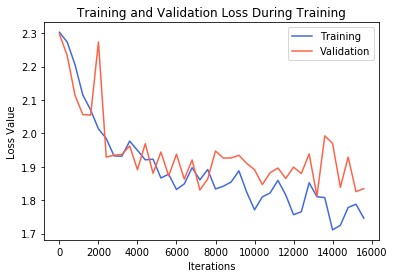

In [60]:
# Generate all possibilities
parameters = [{"batch_size": bs, "lr": lr, "epoch": e} for bs in batch_sizes for lr in learning_rates for e in epochs]

# Will record generalisation error in a 3d tensor.
# i = epoch, j = lr, k = bs
test_error = np.zeros((len(epochs), len(learning_rates), len(batch_sizes)), dtype=object)

DOWNLOAD = True

i, j, k = 0, 0, 0
for params in parameters:

    # TODO several samples for generalization.

    # Reset Network
    net = Net()
    
    # Update train loader and validation loader accordingly
    train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=params["batch_size"],
                                           num_workers=2,
                                           sampler=train_sampler
                                          )
    validation_loader = torch.utils.data.DataLoader(trainset,
                                                batch_size=params["batch_size"],
                                                num_workers=2,
                                                sampler=validation_sampler
                                               )
    
    net = train_network(net, train_loader, validation_loader,
                        batch_size=params['batch_size'], lr=params['lr'], epoch=params['epoch'],
                        download=DOWNLOAD, root_directory=ROOT_DIRECTORY,
                        record_every=RECORD_EVERY)

    test_error[i][j][k] = eval_net(net, testloader)

    # Update of the tensor indices
    i += 1
    if i == test_error.shape[0]:
        j += 1
        i = 0
        if j == test_error.shape[1]:
            k += 1
            j = 0
            if k == test_error.shape[2]:
                k = 0

# Save the error tensor
serializeObject(test_error, ROOT_DIRECTORY + '/test_error.pickle')
    
    
    

### Generate Plot for Accuracy For Different Hyperparameters

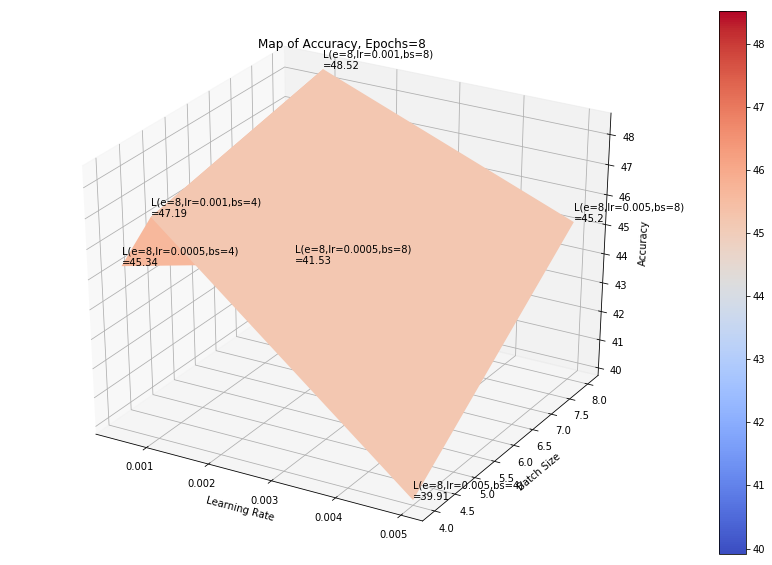

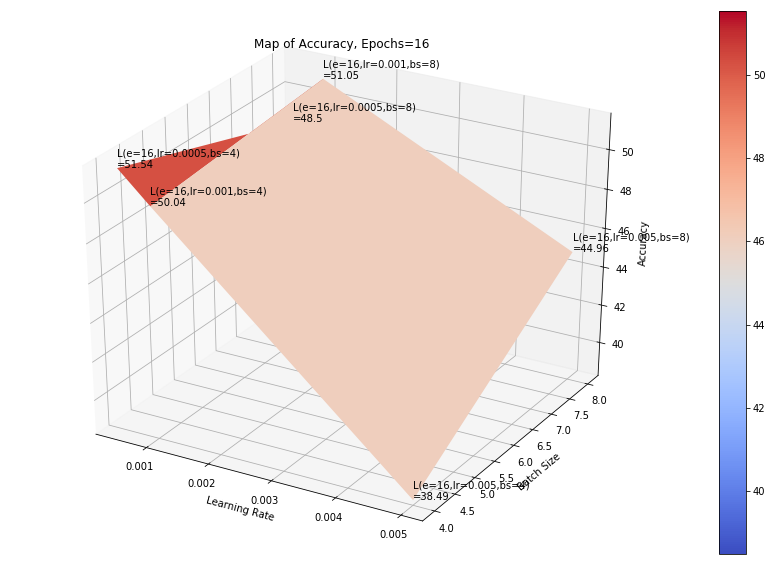

In [0]:


from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

RECOVER=True
if RECOVER:
  test_error=readPickled(ROOT_DIRECTORY + '/test_error.pickle')


# Generate data visualization for test error
X,Y = np.meshgrid(learning_rates, batch_sizes)
for index, e in enumerate(epochs):
    Z = test_error[index].T
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Map of Accuracy, Epochs={0}'.format(e))
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Batch Size')
    ax.set_zlabel('Accuracy')
    # Wireframe
    #ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    # Surface Plot
    surf = ax.plot_surface(
        X, Y, Z,
        cmap=cm.coolwarm,
        norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()),
        rstride=1, cstride=1,
        linewidth=0, antialiased=True)
    fig.colorbar(surf)
    # Coordinates of Points
    for lr_i, lr in enumerate(learning_rates):
        for bs_i, bs in enumerate(batch_sizes):
            coordinates = 'L(e={},lr={},bs={})\n={}'.format(e,lr,bs,test_error[index][lr_i][bs_i])
            ax.text(lr, bs, test_error[index][lr_i][bs_i], coordinates )

plt.show()



##### Analysis
-----

The initial choices provided for the hyperparameters were:

| Hyperparameter  | Choices |
| --------------  | ------- |
| Epochs          | `[1, 2, 4, 8, 16]`    |
| Learning Rate   | `[0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]`    |
| Batch Size      | `[2, 4, 8]`    |

__Ideally__, to study the effects of the choice of the hyperparameters on the performance of the classifier, we would want to test every combination (ex: `{batch_size = 2, learning_rate = 0.0005, epochs = 2}`), at least five times, estimate the perfomance - using the average on five training runs would help provide a less biased estimation of the real performance of the classifier with the given hyperparameters - and compare all of them.

__In Practice__, this method is not efficient and does not leverage the knowledge we already have of the effects of the different hyperparameters on the training of the classifier.

1. Number of Epochs: 

It is defined as the number of times the classifier will be trained on the whole training set. This parameter has a great influence on the model's ability to fit the data. If the number of epoch is too low (e.g 1) then the classifier will only be able to see each image in the dataset once. Therefore preventing any consequential training. This will result in underfitting. On the other hand, if the number of epoch is too high, then the classifier will fit the training data too closely and will have poor generalization ability, as can be seen in the following graph:

![overfitting](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/overfitting.png)


A subset of only 200 pictures from the CIFAR-10 dataset was used to train the pre-defined convolutional neural network for 50 epochs. The overfitting appears quite clearly; the training loss keeps decreasing while the validation loss increases. 

Finding the optimal number of epochs therefore requires to monitor the evolution of the training and validation loss, until a divergence occurs. Generally, the most complex the model trained is, the later this divergence occurs. State of the art, or near state of the art models on the CIFAR-10, such as [1], reach their maximal accuracy with a great number of epochs (300 epochs for [1]), but have greater parametrical complexity (greater than a million for [1], versus the 61250 parameters of the pre-defined model for this part of the assignment).


**I therefore chose to disregard the values of epochs 1, 2 and 4 right away. It leaves `[8, 16]` epochs to try out**

2. Learning Rate

The learning rate defines the speed at which the parameters of the model will be updated during the gradient descent or backpropagation. This parameter is probably the most important to fine-tune to achieve maximal accuracy. It is also dependant on the model and the dataset. Indeed, the loss function is a mapping between a highly multidimensional space (the data and the parameters) and a value that we seek to minimize on the subspace of the parameters.

The following graphs help visualize the influence of the learning rate on the convergence of a function (the loss to minimize).

If the learning rate is too low, the gradient descent will require many iterations, and might result in finding only a local minimum

![low_lr](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/low_lr.png)

With a good learning rate, local mimima are avoided and the global minima can be reached

![good_lr](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/good_lr.png)

With a too high learning rate, the gradient descent will struggle to converge, even to local minima.

![high_lr](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/high_lr.png)

**I will therefore need to study the evolution of the accuracy on all possible learning rates, i.e `[0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]`**



3. Batch Size


Finally, the batch size determines the number of samples drawn from the dataset at each iteration. Intuitively, one might want to use the whole dataset as a single batch, to ensure that the data used to perform an update of the parameters of the model matches as closely as possible the real distribution of data. But this is generally not possible, due to memory limitations. By assuming that the data elements are independently drawn from the same distribution, using a sufficient number of batches of smaller size will converge to the same minimum.

Considering the batch elements as independent samples from a distribution explains why a larger bach size leads to a more stable convergence, and [2] shows that larger batch sizes lead to an overall best performances.

**I therefore chose to only include the two largest batch size options in my comparison, i,e `[4, 8]`**


### Part 3: More options

Please indicate the **three** tasks you are assigned here:

SID:490547607

1) Transformation: Center Crop/FiveCrop + Resize

2) Structure: Channel Number

3) Training procedure: lr_scheduler Lambda

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1) 

2) 


_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) 

2) 


_____

### Reference
1. Huang, Gao, et al. "Densely connected convolutional networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
2. McCandlish, Sam, et al. "An empirical model of large-batch training." arXiv preprint arXiv:1812.06162 (2018).
1. http://www.cs.toronto.edu/~hinton/absps/momentum.pdf - Momentum
2. https://arxiv.org/pdf/1905.11946v2.pdf - Efficient Net, scale of networks
3. https://arxiv.org/pdf/1506.01186.pdf cyclical lr -> implementation
4. Y. Bengio. Neural Networks: Tricks of the Trade, chapter Practical recommendations for gradient-based training of
deep architectures, pages 437–478. Springer Berlin Heidelberg, 2012. -> details on LR setting
5. https://openai.com/blog/science-of-ai/ -> Batch Size scaling

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your pytorch software versions.